In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
 
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
 
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Sumin Seo\AppData\Roaming\Python\Python36\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 데이터 준비하기

In [2]:
df = pd.DataFrame()

In [3]:
df = pd.read_pickle('data/clean_train_abstract')
#with open('data/clean_train_abstract', 'rb') as f:
#    df = pickle.load(f)
df.head()

,ISSN,date,topic,title,raw_abstract,clean_train_abstract
0,1545-5963,2018/05,IEEE/ACM Transactions on Computational Biology...,Simulating the Large-Scale Erosion of Genomic ...,The dramatically decreasing costs of DNA seque...,dramat decreas cost dna sequenc trigger millio...
1,1545-5963,2018/05,IEEE/ACM Transactions on Computational Biology...,Protecting Privacy and Security of Genomic Dat...,Re-use of patients’ health records can provide...,use patient health record provid tremend benef...
2,1545-5963,2018/05,IEEE/ACM Transactions on Computational Biology...,Implementation and Evaluation of an Algorithm ...,We improve the quality of cryptographically pr...,improv qualiti cryptograph privaci preserv gen...
3,1545-5963,2018/05,IEEE/ACM Transactions on Computational Biology...,Identification and Analysis of Key Residues in...,Protein–RNA complexes play important roles in ...,protein rna complex play import role various b...
4,1545-5963,2018/05,IEEE/ACM Transactions on Computational Biology...,Unified Deep Learning Architecture for Modelin...,Prediction of the spatial structure or functio...,predict spatial structur function biolog macro...


In [4]:
# pre-processing
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

data_words =list(sent_to_words(df['clean_train_abstract']))
print(data_words[:2])

[['dramat', 'decreas', 'cost', 'dna', 'sequenc', 'trigger', 'million', 'human', 'genotyp', 'sequenc', 'moreov', 'individu', 'increas', 'make', 'genom', 'data', 'public', 'avail', 'therebi', 'creat', 'privaci', 'threat', 'relat', 'dna', 'similar', 'general', 'entiti', 'gain', 'access', 'signific', 'fraction', 'sequenc', 'genotyp', 'might', 'abl', 'infer', 'even', 'genom', 'unsequenc', 'individu', 'paper', 'propos', 'simul', 'base', 'model', 'quantifi', 'impact', 'continu', 'sequenc', 'public', 'person', 'genom', 'data', 'popul', 'genom', 'privaci', 'simul', 'probabilist', 'model', 'data', 'share', 'take', 'account', 'event', 'migrat', 'interraci', 'mate', 'exemplarili', 'instanti', 'simul', 'sampl', 'popul', 'individu', 'evalu', 'privaci', 'multipl', 'set', 'genom', 'variant', 'subset', 'phenotyp', 'relat', 'variant', 'find', 'demonstr', 'increas', 'share', 'rate', 'futur', 'entail', 'substanti', 'negat', 'effect', 'privaci', 'older', 'generat', 'moreov', 'find', 'mix', 'popul', 'face',

# 연도 별로 토픽 분포 나타내기

1. 연도가 x축
2. 토픽은 색깔로
3. y축은 분포도
4. 다 함수화할 것이다. 연도별로 loop 돌릴 것이라

In [6]:
#for i in ragne(1995, 2019):
#    criterion = df['date'].map(lambda x: x.startswith(str(i)))
#    df[criterion]

"for i in ragne(1995, 2019):\n    criterion = df['date'].map(lambda x: x.startswith(str(i)))\n    df[criterion]"

In [67]:
# 특정 년도만 data frame에 넣기
criterion = df['date'].map(lambda x: x.startswith(str(1995)))
df2 = df[criterion]

In [8]:
data_words =list(sent_to_words(df2['clean_train_abstract']))
print("Import data...")
print(data_words[:2])

Import data...
[['futur', 'bisdn', 'network', 'signific', 'burden', 'place', 'process', 'element', 'network', 'sinc', 'call', 'rout', 'admiss', 'polici', 'comput', 'intens', 'present', 'day', 'network', 'thus', 'bottleneck', 'futur', 'network', 'like', 'shift', 'communic', 'link', 'process', 'element', 'delay', 'element', 'influenc', 'process', 'capac', 'factor', 'rout', 'algorithm', 'propag', 'delay', 'admiss', 'control', 'function', 'network', 'topolog', 'goal', 'paper', 'character', 'behavior', 'factor', 'call', 'setup', 'time', 'accept', 'call', 'throughput', 'behavior', 'examin', 'three', 'sequenti', 'rout', 'scheme', 'two', 'flood', 'rout', 'scheme', 'various', 'network', 'paramet', 'differ', 'form', 'admiss', 'control', 'result', 'studi', 'indic', 'process', 'capac', 'admiss', 'control', 'function', 'affect', 'call', 'setup', 'time', 'accept', 'call', 'throughput', 'signific', 'propag', 'delay', 'affect', 'perform', 'measur', 'signific'], ['softwar', 'implement', 'error', 'detec

In [9]:
#바이그램(ngram 적용 -> 교수님 조언대로 바꿔서 성능 테스트하기)
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20)

#바이그램을 효율 높이기
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = [bigram_mod[word] for word in data_words]

#바이그램 적용 결과 예시
print("\nRaw data")
print(data_words[0][:10])

print("\nBigram...")
print(bigram_mod[data_words[0]][:10])


Raw data
['futur', 'bisdn', 'network', 'signific', 'burden', 'place', 'process', 'element', 'network', 'sinc']

Bigram...
['futur', 'bisdn', 'network', 'signific', 'burden', 'place', 'process_element', 'network', 'sinc', 'call']


In [37]:
# Create Dictionary
# id2word: what word a given id corresponds to, pass the id as a key to the dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams
print(texts[:5])

[['futur', 'bisdn', 'network', 'signific', 'burden', 'place', 'process_element', 'network', 'sinc', 'call', 'rout', 'admiss', 'polici', 'comput', 'intens', 'present', 'day', 'network', 'thus', 'bottleneck', 'futur', 'network', 'like', 'shift', 'communic', 'link', 'process_element', 'delay', 'element', 'influenc', 'process', 'capac', 'factor', 'rout', 'algorithm', 'propag_delay', 'admiss', 'control', 'function', 'network', 'topolog', 'goal', 'paper', 'character', 'behavior', 'factor', 'call', 'setup', 'time', 'accept', 'call', 'throughput', 'behavior', 'examin', 'three', 'sequenti', 'rout', 'scheme', 'two', 'flood', 'rout', 'scheme', 'various', 'network', 'paramet', 'differ', 'form', 'admiss', 'control', 'result', 'studi', 'indic', 'process', 'capac', 'admiss', 'control', 'function', 'affect', 'call', 'setup', 'time', 'accept', 'call', 'throughput', 'signific', 'propag_delay', 'affect', 'perform', 'measur', 'signific'], ['softwar', 'implement', 'error_detect', 'code', 'consid', 'slow', 

In [44]:
# Term Document Frequency
# corpus: (word_id, word_frequency)
# doc2bow: Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.

dct = Dictionary(["this is a cat".split(), "this is máma".split()])
print(dct)
print(dct.doc2bow(["this", "is", "máma"]))
print(dct.doc2bow(["this", "is", "máma"], return_missing=True))

Dictionary(5 unique tokens: ['a', 'cat', 'is', 'this', 'máma'])
[(2, 1), (3, 1), (4, 1)]
([(2, 1), (3, 1), (4, 1)], {})


In [45]:
corpus = [id2word.doc2bow(text) for text in texts]
#corpora.Dictionary(texts) = id2word.doc2bow(text)
print("\nBuild Corpus")
print(corpus[0][:5])


Build Corpus
[(0, 2), (1, 4), (2, 2), (3, 1), (4, 2)]


In [11]:
#토픽 모델링 모델 -> 전달값에 따른 상이한 결과를 보임
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=20,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

Modeling...


In [12]:
topics = np.array(lda_model.print_topics())
print("Topics")
print(topics)

Topics
[['0'
  '0.076*"motion" + 0.054*"code" + 0.049*"abl" + 0.039*"comput" + 0.027*"parallel" + 0.027*"weight" + 0.023*"correct" + 0.022*"help" + 0.021*"ari" + 0.019*"learn"']
 ['1'
  '0.029*"algorithm" + 0.021*"use" + 0.019*"abstract" + 0.017*"base" + 0.013*"problem" + 0.013*"comput" + 0.012*"present" + 0.011*"approach" + 0.011*"two" + 0.011*"result"']
 ['2'
  '0.043*"critic" + 0.039*"ridg" + 0.039*"oak" + 0.039*"courtesi" + 0.032*"purpos" + 0.025*"generat" + 0.024*"volumetr" + 0.022*"sphere" + 0.020*"nation" + 0.019*"brook"']
 ['3'
  '0.048*"wavelet" + 0.031*"radios" + 0.027*"hierarchi" + 0.022*"calcul" + 0.021*"method" + 0.020*"third" + 0.020*"power" + 0.019*"exclus" + 0.019*"estim" + 0.017*"equat"']
 ['4'
  '0.102*"visual" + 0.086*"data" + 0.034*"understand" + 0.032*"pixel" + 0.024*"languag" + 0.024*"compil" + 0.017*"facil" + 0.016*"view" + 0.016*"environ" + 0.014*"emphasi"']
 ['5'
  '0.050*"onto" + 0.042*"node" + 0.031*"hypercub" + 0.027*"tree" + 0.026*"mesh" + 0.026*"algorithm"

In [13]:
# LDA 모델 코퍼스가 어떻게 생겼는지 확인하기

# Convert to list
#data = df.clean_train_abstract.values.tolist()

for i in range(5):
    for j in range(5):
        print(i,j)
        print(lda_model[corpus][i][j])

0 0
[(1, 0.28791696), (9, 0.013018144), (10, 0.23551326), (14, 0.14703865), (15, 0.031940423), (16, 0.25027993)]
0 1
[(0, [16]), (1, [16]), (2, [10]), (3, [1]), (4, [15, 1]), (5, [16]), (6, [16]), (7, [16]), (8, [14, 1, 16]), (9, [10]), (10, [1]), (11, [10, 1, 15]), (12, [1, 10, 15]), (13, [10, 15, 13]), (14, [1]), (15, [10]), (16, [1, 10]), (17, [10]), (18, [16, 1]), (19, [10, 1]), (20, [16]), (21, [1]), (22, [16, 1]), (23, [16, 14]), (24, [16]), (25, [1]), (26, [16]), (27, [10]), (28, [1, 16]), (29, [14, 10]), (30, [1, 15]), (31, [14, 10, 1]), (32, [1, 15]), (33, [1, 6]), (34, [10, 1, 15, 9]), (35, [16]), (36, [9, 13]), (37, [1, 14, 15]), (38, [16, 1, 10]), (39, [1]), (40, [16]), (41, [1, 10]), (42, [14]), (43, [10, 1]), (44, [10]), (45, [16]), (46, [16, 13]), (47, [1, 10]), (48, [1]), (49, [10, 1, 16, 14, 15]), (50, [1]), (51, [10]), (52, [10, 1]), (53, [10, 1, 9, 15]), (54, [1]), (55, [1, 14]), (56, [15, 1, 10])]
0 2
[(0, [(16, 2.0000002)]), (1, [(16, 3.9997685)]), (2, [(10, 2.0)])

IndexError: tuple index out of range

In [26]:
from itertools import chain

In [30]:
# 방법2 'How do we see which document belong to which topic after doing LDA in python'
lda_corpus = corpus
data = data_words_bigrams
scores = list(chain(*[[score for topic_id, score in topic] \
                      for topic in [doc for doc in corpus]]))
threshold = sum(scores)/len(scores)
print (threshold)

cluster1 = [j for i,j in zip(lda_corpus, data) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus, data) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda_corpus, data) if i[2][1] > threshold]

#print (cluster1) [0][0]
#print (cluster2)
#print (cluster3)

1.488421360216232


# Perplexity & Coherence

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.324123370311011

Coherence Score:  0.3582608325924312


## Perplexity

깁스샘플링 과정에서 반복횟수가 증가할수록 Perplexity는 감소하는 경향을 띕니다. 그러다가 특정 시점을 지나면 더 이상 Perplexity는 감소하지 않고 증가, 감소를 반복하며 요동치는 지점이 등장하는데요, 이때를 해당 깁스 샘플링의 수렴 지점으로 보고 샘플링을 멈추는 경우가 많습니다. 그리고 이때의 Perplexity가 해당 모델의 최종 Perplexity가 되겠죠. 이 값이 작으면 작을수록 해당 토픽 모델은 실제 문헌 결과를 잘 반영한다는 뜻이므로 학습이 잘 되었다고 평가를 할 수 있겠습니다. 이 값은 LDA 등에서 적절한 주제 개수를 정하기 어려울때 유용하게 쓰입니다. 다양한 주제 개수로 학습을 진행해보면 주제 개수가 몇일때 Perplexity가 최소가 되는지 알 수 있기 때문이죠.

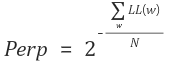

## Coherence Score
토픽이 얼마나 의미론적으로 일관성 있는지 알아보는 척도. 높을수록 의미론적 일관성 높다. 해당 모델이 얼마나 실제로 의미있는 결과를 내는지 확인하기 위해 사용

출처: https://bab2min.tistory.com/587 [나의 큰 O는 logx야..]

# Gensim 연습

In [31]:
# print the most contributing words for 20 randomly selected topics
lda_model.print_topics(20)

[(0,
  '0.076*"motion" + 0.054*"code" + 0.049*"abl" + 0.039*"comput" + 0.027*"parallel" + 0.027*"weight" + 0.023*"correct" + 0.022*"help" + 0.021*"ari" + 0.019*"learn"'),
 (1,
  '0.029*"algorithm" + 0.021*"use" + 0.019*"abstract" + 0.017*"base" + 0.013*"problem" + 0.013*"comput" + 0.012*"present" + 0.011*"approach" + 0.011*"two" + 0.011*"result"'),
 (2,
  '0.043*"critic" + 0.039*"ridg" + 0.039*"oak" + 0.039*"courtesi" + 0.032*"purpos" + 0.025*"generat" + 0.024*"volumetr" + 0.022*"sphere" + 0.020*"nation" + 0.019*"brook"'),
 (3,
  '0.048*"wavelet" + 0.031*"radios" + 0.027*"hierarchi" + 0.022*"calcul" + 0.021*"method" + 0.020*"third" + 0.020*"power" + 0.019*"exclus" + 0.019*"estim" + 0.017*"equat"'),
 (4,
  '0.102*"visual" + 0.086*"data" + 0.034*"understand" + 0.032*"pixel" + 0.024*"languag" + 0.024*"compil" + 0.017*"facil" + 0.016*"view" + 0.016*"environ" + 0.014*"emphasi"'),
 (5,
  '0.050*"onto" + 0.042*"node" + 0.031*"hypercub" + 0.027*"tree" + 0.026*"mesh" + 0.026*"algorithm" + 0.021

In [59]:
print(lda_model.get_document_topics(id2word.doc2bow(["user"])))  # user 단어의 document 소환?

[(0, 0.018692138), (1, 0.30608934), (2, 0.010982693), (3, 0.023833016), (4, 0.022675643), (5, 0.022747302), (6, 0.042502187), (7, 0.01796564), (8, 0.03272812), (9, 0.011739199), (10, 0.0607689), (11, 0.051674828), (12, 0.019652043), (13, 0.049386602), (14, 0.15487927), (15, 0.06821019), (16, 0.022792172), (17, 0.017105367), (18, 0.014712134), (19, 0.030863237)]


## TF-IDF (Term Frequency - Inverse Document Frequency)
TF-IDF(Term Frequency - Inverse Document Frequency)는 정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용할 수 있다.

TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

코드: https://radimrehurek.com/gensim/tut2.html#transformation-interface

참고 :
https://ko.wikipedia.org/wiki/Tf-idf
https://wikidocs.net/21328

In [51]:
from gensim import corpora, models, similarities

# Creating a transformation
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]
print(corpus_tfidf[10])

[(4, 0.04778206933936841), (8, 0.0337525643638733), (13, 0.07601652677381286), (31, 0.05390187279339919), (32, 0.0173762723682207), (41, 0.017577828192462983), (55, 0.021698885573731258), (58, 0.02196075164567137), (79, 0.11543007902532301), (90, 0.02625314931945666), (93, 0.03544502246628668), (95, 0.024730556115885583), (103, 0.04427529709412848), (112, 0.02305151322348283), (136, 0.05205382494057911), (139, 0.15352885542363714), (172, 0.0990680399972957), (179, 0.21026276216320866), (192, 0.07676442771181857), (221, 0.059307825951109824), (233, 0.04737147682625347), (241, 0.18478894876547944), (245, 0.07891020356212439), (247, 0.06409144715254358), (248, 0.5855733639269244), (250, 0.037329469060907415), (264, 0.029376183563476554), (266, 0.04778206933936841), (267, 0.04737147682625347), (269, 0.019061577038858347), (275, 0.11132767625542596), (287, 0.04160365408018166), (322, 0.040228643667720436), (374, 0.058478651147140584), (386, 0.09315902078532341), (415, 0.06201021539844038), 

In [54]:
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=id2word, num_topics=20)

In [55]:
lda_model_tfidf.print_topics(2)

[(9,
  '0.003*"object" + 0.003*"system" + 0.002*"color" + 0.002*"model" + 0.002*"test" + 0.002*"perform" + 0.002*"vote" + 0.002*"decod" + 0.002*"reachabl" + 0.002*"lock_free"'),
 (10,
  '0.003*"qualiti" + 0.003*"network" + 0.002*"data" + 0.002*"product" + 0.002*"improv" + 0.002*"atm_switch" + 0.002*"rm" + 0.002*"signatur" + 0.002*"comput" + 0.002*"cost"')]

## TF-IDF와 LDA 모델을 활용해 dominant topic 찾아보기

## 18. Finding the dominant topic in each sentence

In [56]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [64]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus, texts=data_words_bigrams)

In [137]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head() # 열: 문서수

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.6801,"qualiti, network, data, product, improv, atm_s...","[futur, bisdn, network, signific, burden, plac..."
1,1,15.0,0.4499,"fault, algorithm, program, structur, cluster, ...","[softwar, implement, error_detect, code, consi..."
2,2,2.0,0.5983,"schedul, render, task, fault, network, paralle...","[buffer_alloc, provid, effici, fair, use, avai..."
3,3,6.0,0.9013,"network, circuit, system, algorithm, design, d...","[show, modul, sourc, rate, video, encod, base,..."
4,4,4.0,0.5732,"surfac, messag, model, softwar, distanc, invar...","[packet_switch, network, communic, channel, st..."
5,5,14.0,0.7299,"test, system, path, inconsist, program, model,...","[patel, propos, probabilist, approach, analyz,..."
6,6,0.0,0.6329,"network, partit, secur, disk, subcub, processo...","[paper, propos, new, medium, access, control, ..."
7,7,8.0,0.5645,"transact, cluster, approach, motion, real, mod...","[singl, fault, larg, communic, network, may, r..."
8,8,5.0,0.5877,"queri, optim, distribut, model, network, perfo...","[switch, boundari, cellular, system, necessari..."
9,9,19.0,0.4357,"traffic, string, node, network, fht, binar, al...","[virtual_path, vp, concept, gain, attent, term..."


## 19. Find the most representative document for each topic

In [169]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

sent_topics_grpd

In [170]:
for i, grp in sent_topics_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted,
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                    axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9383,"network, partit, secur, disk, subcub, processo...","[abstract, multiway, merg, sort, network, pres..."
1,1.0,0.9627,"checkpoint, curv, camera, task, imag, time, al...","[ieee, transact, pattern, analysi, machin, int..."
2,2.0,0.9842,"schedul, render, task, fault, network, paralle...","[abstract, consid, problem, schedul, task, imp..."
3,3.0,0.9683,"power_dissip, test, algorithm, permut, object,...","[present, analyt_model, electr, character, con..."
4,4.0,0.9789,"surfac, messag, model, softwar, distanc, invar...","[abstract, show, automat, acquir, euclidian, s..."
5,5.0,0.8503,"queri, optim, distribut, model, network, perfo...","[present, analysi, network, perform, degrad, i..."
6,6.0,0.9875,"network, circuit, system, algorithm, design, d...","[abstract, consid, problem, find, worst_case, ..."
7,7.0,0.9830,"model, code, smalltalk, reliabl, system, proce...","[abstract, techniqu, creat, search, tree, patt..."
8,8.0,0.9635,"transact, cluster, approach, motion, real, mod...","[abstract_paper, describ, system, detect, trac..."
9,9.0,0.9712,"object, system, color, model, test, perform, v...","[abstract, construct, method, systemat, uec, c..."


## 20. Topic distribution across documents

In [171]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
#print(type(topic_counts))

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_counts.sort_index(ascending=True, inplace=True)
topic_contribution.sort_index(ascending=True, inplace=True)

#print(topic_counts)
#print(topic_contribution)

topic_table = pd.concat([topic_counts, topic_contribution], axis=1)
topic_table.columns = ['Num_Documents', 'Perc_Documents']
topic_table.sort_index(ascending=True, inplace=True)
topic_table.reset_index()
topic_table

,Num_Documents,Perc_Documents
0.0,37,0.0523
1.0,38,0.0537
2.0,56,0.0791
3.0,37,0.0523
4.0,36,0.0508
5.0,31,0.0438
6.0,53,0.0749
7.0,39,0.0551
8.0,31,0.0438
9.0,27,0.0381


In [189]:
# 아래 내용은 오류가 있는 듯하다.

# Topic Number and Keywords
#print(df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].head())
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([sent_topics_sorted, topic_table], axis=1)
#df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.drop(columns='Topic_Perc_Contrib', inplace=True)

# Sort
df_dominant_topics.sort_values(by=['Num_Documents'],ascending=False, inplace=True)
df_dominant_topics = df_dominant_topics[['Num_Documents', 'Perc_Documents', 'Topic_Num', 'Keywords', 'Text']].reset_index(drop=True)

# Change Column names
#df_dominant_topics.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_dominant_topics.head(20)

,Num_Documents,Perc_Documents,Topic_Num,Keywords,Text
0,56,0.0791,2.0,"schedul, render, task, fault, network, paralle...","[abstract, consid, problem, schedul, task, imp..."
1,53,0.0749,6.0,"network, circuit, system, algorithm, design, d...","[abstract, consid, problem, find, worst_case, ..."
2,47,0.0664,15.0,"fault, algorithm, program, structur, cluster, ...","[abstract, experiment, comparison, shape, clas..."
3,39,0.0551,7.0,"model, code, smalltalk, reliabl, system, proce...","[abstract, techniqu, creat, search, tree, patt..."
4,38,0.0537,1.0,"checkpoint, curv, camera, task, imag, time, al...","[ieee, transact, pattern, analysi, machin, int..."
5,37,0.0523,0.0,"network, partit, secur, disk, subcub, processo...","[abstract, multiway, merg, sort, network, pres..."
6,37,0.0523,3.0,"power_dissip, test, algorithm, permut, object,...","[present, analyt_model, electr, character, con..."
7,37,0.0523,14.0,"test, system, path, inconsist, program, model,...","[abstract, tempor, databas, contain, time, var..."
8,36,0.0508,4.0,"surfac, messag, model, softwar, distanc, invar...","[abstract, show, automat, acquir, euclidian, s..."
9,35,0.0494,16.0,"test, pdi, solut, problem, data, strategi, cue...","[abstract, deriv, exact, solut, problem, estim..."


# Visualizing

In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Sumin Seo\AppData\Roaming\Python\Python36\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.236962  0.005755       1        1  37.004990
10     0.159551 -0.047708       2        1   8.749511
15     0.196786  0.137147       3        1   6.511840
6      0.197722  0.073703       4        1   4.976208
11     0.157501 -0.209807       5        1   4.679672
13     0.063667 -0.026811       6        1   4.633031
14     0.002124  0.122215       7        1   3.826322
8     -0.000638  0.116013       8        1   3.627514
5     -0.090112  0.084050       9        1   3.497760
19    -0.123592 -0.229748      10        1   2.896679
16     0.001486 -0.116702      11        1   2.837499
3     -0.086197 -0.057589      12        1   2.417468
7     -0.110427  0.000007      13        1   2.327696
4      0.034845 -0.115256      14        1   2.177692
0     -0.096920  0.029818      15        1   1.993588
18    -0.084027  0.078173      16        1   1.858970
9     -0.084482  0.073864      17        1   1.823091
12    -0.089000  0.087269      18        1   1.734092
17    -0.148707 -0.043082      19        1   1.423916
2     -0.136542  0.038689      20        1   1.002461, topic_info=     Category        Freq                Term       Total  loglift  logprob
term                                                                       
294   Default  657.000000                data  657.000000  30.0000  30.0000
31    Default  373.000000             network  373.000000  29.0000  29.0000
269   Default  543.000000               model  543.000000  28.0000  28.0000
111   Default  631.000000              system  631.000000  27.0000  27.0000
3     Default  714.000000           algorithm  714.000000  26.0000  26.0000
76    Default  382.000000              design  382.000000  25.0000  25.0000
12    Default  402.000000              comput  402.000000  24.0000  24.0000
2425  Default  224.000000              visual  224.000000  23.0000  23.0000
1873  Default  185.000000              render  185.000000  22.0000  22.0000
187   Default  211.000000         architectur  211.000000  21.0000  21.0000
53    Default  316.000000                time  316.000000  20.0000  20.0000
138   Default  202.000000               estim  202.000000  19.0000  19.0000
148   Default  400.000000              method  400.000000  18.0000  18.0000
426   Default  172.000000                test  172.000000  17.0000  17.0000
2416  Default  160.000000                imag  160.000000  16.0000  16.0000
562   Default  168.000000              featur  168.000000  15.0000  15.0000
105   Default  168.000000             softwar  168.000000  14.0000  14.0000
314   Default  168.000000            structur  168.000000  13.0000  13.0000
34    Default  410.000000             perform  410.000000  12.0000  12.0000
164   Default  383.000000              propos  383.000000  11.0000  11.0000
185   Default  856.000000                 use  856.000000  10.0000  10.0000
312   Default  188.000000               simul  188.000000   9.0000   9.0000
774   Default  193.000000            parallel  193.000000   8.0000   8.0000
171   Default  238.000000                 set  238.000000   7.0000   7.0000
118   Default  358.000000            approach  358.000000   6.0000   6.0000
90    Default  232.000000           implement  232.000000   5.0000   5.0000
667   Default  140.000000             program  140.000000   4.0000   4.0000
135   Default   97.000000               dynam   97.000000   3.0000   3.0000
1955  Default   93.000000              motion   93.000000   2.0000   2.0000
58    Default  206.000000                also  206.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
4127  Topic20   11.898568               volvi   12.736553   4.5347  -3.9415
4125  Topic20   11.898568                suni   12.736553   4.5347  -3.9415
4124  Topic20   11.898568               stoni   12.736553   4.5347  -3.9415
4123  Topic20   11.898568        